In [1]:
import numpy as np
import torch
import os
import torchvision.transforms as T
from PIL import Image, ImageColor

In [2]:
data_root = './carseg_data-2/arrays'

### Some data handling functions:

In [15]:
parts = {10: {'col': 'orange', 'name':'hood'}, 
         20: {'col':'darkgreen', 'name':'front door'}, 
         30: {'col':'yellow', 'name':'rear door'}, 
         40: {'col':'cyan', 'name':'frame'}, 
         50: {'col':'purple', 'name':'rear quarter panel'}, 
         60: {'col':'lightgreen', 'name':'trunk lid'}, 
         70: {'col':'blue', 'name':'fender'}, 
         80: {'col':'pink', 'name':'bumper'}, 
         90: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = np.moveaxis(data_arr.numpy().astype(np.uint8), 0, 2)
    elif data_arr.shape[0] == 3: data_arr = np.moveaxis(data_arr.astype(np.uint8), 0, 2)
    elif data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter
    
def display_labels(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = data_arr.numpy()
    if data_arr.dtype != np.uint8: data_arr = data_arr.astype(np.uint8)*10
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)
    
def numpy_to_tensor(arr):
    return np.moveaxis(arr, 2, 0).astype(np.float32)

def tensor_to_numpy(tens):
    arr = np.moveaxis(tens, 0, 2).astype(np.uint8)
    return arr

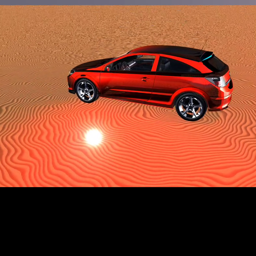

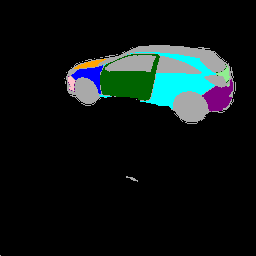

In [7]:
arr = np.load(os.path.join(data_root,'orange_3_doors_0101.npy'))
display_car(arr)
display_labels(arr)

### Dataset class:

In [13]:
import os
import numpy as np
from torch.utils.data import Dataset
from skimage.transform import resize

class CarDataset(Dataset):
    def __init__(self, root, file_list: list=None):
        self.root = root
        self.filenames = os.listdir(self.root) if file_list is None else file_list
        
    def __len__(self):
        return len(self.filenames)
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        car = arr[:,:,0:3]
        # Resize function does not work on int dtypes, so we must convert to float before
        car = resize(car.astype(np.float32), (256, 256))
        # Convert to the torch tensor image convention (CxWxH)
        car = np.moveaxis(car, 2, 0)
        labels = arr[:,:,3]
        labels = resize(labels.astype(np.float32), (256, 256))
        
        return torch.tensor(car), torch.tensor(labels/10)

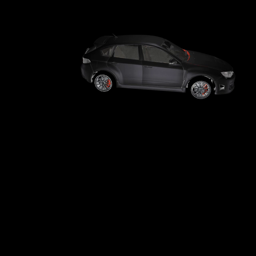

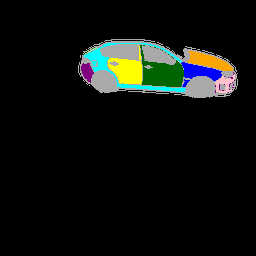

In [16]:
ds = CarDataset(data_root)
car, labels = ds[0]
display_car(car)
display_labels(labels)

### Dataset analysis

In [17]:
black_car = []
orange_car = []
photos = []
for file in os.listdir(data_root):
    if 'orange' in file: orange_car.append(file)
    elif 'black' in file: black_car.append(file)
    elif 'photo' in file: photos.append(file)

print(f'Orange car ds length: {len(orange_car)}\nBlack car ds length: {len(black_car)}\nPhoto ds length: {len(photos)}')

Orange car ds length: 2001
Black car ds length: 834
Photo ds length: 168


### UNet model definition

In [18]:
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder0 = nn.Sequential(ConvBlock(in_channels, 64))
        self.encoder1 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(64, 128))
        self.encoder2 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(128, 256))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(256,512), nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder0 = nn.Sequential(ConvBlock(512,256), nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder1 = nn.Sequential(ConvBlock(256,128), nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder2 = nn.Sequential(ConvBlock(128,64), nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1))
        
    def forward(self, x):
        # Add dimension if input is not batched
        if x.ndim == 3: x = x.unsqueeze(0)
            
        x0 = self.encoder0(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.bottleneck(x2)
        x3 = self.decoder0(torch.cat([x2,x3],dim=1))
        x3 = self.decoder1(torch.cat([x1,x3],dim=1))
        x3 = self.decoder2(torch.cat([x0,x3],dim=1))
        
        return x3
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x)

### Training time!

First we define the dataset splits. We divide the 3 different datasets, so that we can later compare them

In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

photo_train, photo_test = train_test_split(photos, test_size=0.2, random_state=42)
black_train, black_test = train_test_split(black_car, test_size=0.2, random_state=42)
orange_train, orange_test = train_test_split(orange_car, test_size=0.2, random_state=42)

joint_train_ds = CarDataset(data_root, photo_train+black_train+orange_train)
joint_test_ds = CarDataset(data_root, photo_test+black_test+orange_test)
photo_test_ds = CarDataset(data_root, photo_test)
black_test_ds = CarDataset(data_root, black_test)
orange_test_ds = CarDataset(data_root, orange_test)

train_dl = DataLoader(joint_train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(joint_test_ds, batch_size=16)

In [21]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from torchmetrics.functional import dice

device = torch.device('cuda')
model = UNet(3,10)
model = model.to(device)

#train_size = int(len(ds)*0.8)
#test_size = len(ds)-train_size
#train_ds, test_ds = random_split(ds, [train_size, test_size])
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
#test_dl = DataLoader(test_ds, batch_size=8)

epochs = 20
lr = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

avg_train_losses = []
avg_test_losses = []
avg_test_dices = []
for epoch in range(epochs):
    torch.cuda.empty_cache()
    print(f'Starting epoch{epoch}')
    epoch_loss = []
    model.train()
    for batch, (X, Y) in enumerate(train_dl):
        if batch%10 == 0: print(f'\tStarting batch {batch}')
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        out = model(X)
        #out = torch.nn.Softmax2d()(out)
        loss = loss_fn(out,Y.long())
        #loss = loss_fn(Y,out[:,1,:,:])
        loss.backward()
        optimizer.step()
        loss_val = loss.detach().cpu()
        epoch_loss.append(loss_val)
      
    avg_loss = np.mean(epoch_loss)
    avg_train_losses.append(avg_loss)
    print(f'Avg epoch loss: {avg_loss}')
    
    torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        test_loss = []
        test_dice = []
        for batch, (X, Y) in enumerate(test_dl):
            X = X.to(device)
            Y = Y.to(device)

            out = model(X)
            #out = softmax2d(out)
            loss = loss_fn(out,Y.long())
            dice_score = dice(out, Y.int())
            #loss = criterion(Y,out[:,1,:,:])
            test_loss.append(loss.detach().cpu())
            test_dice.append(dice_score.detach().cpu())        
        
    avg_test_loss = np.mean(test_loss)
    avg_test_losses.append(avg_test_loss)
    print(f'Avg epoch test loss: {avg_test_loss}')
    avg_test_dice = np.mean(test_dice)
    avg_test_dices.append(avg_test_dice)
    print(f'Avg epoch test dice: {avg_test_dice}')
    
    # Remove the '.' in the dice score to put in the model name. It's always 0.x anyway.
    str_dice = f'{avg_test_dice:.4f}'.replace('.','')
    torch.save(model.state_dict(), f"./Models/checkpoint/model_{epoch}_epochs_dice_{str_dice}.pth")
    

Starting epoch0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch loss: 0.7212197184562683
Avg epoch test loss: 0.7656238079071045
Avg epoch test dice: 0.7317883372306824
Starting epoch1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch loss: 0.41028937697410583
Avg epoch test loss: 0.4732198715209961
Avg epoch test dice: 0.8625103831291199
Starting epoch2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch loss: 0.3381741940975189
Avg epoch test loss: 0.3405705988407135
Avg epoch test dice: 0.8758132457733154
Starting epoch3
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch loss: 0.2958289682865143
Avg epoch test loss: 0.2660285532474518
Avg epoch test dice: 0.8997011780738831
Starting epoch4
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch loss: 0.26617568731307983
Avg epoch test loss: 0.4094134569168091
Avg epoch test dice: 0.8711901307106018
Starting epoch5
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Avg epoch

In [8]:
torch.save(model.state_dict(), f"./test_model_20_epochs_batch16.pth")

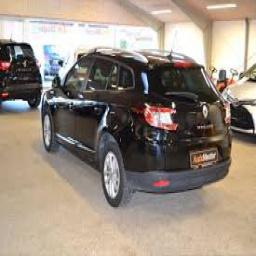

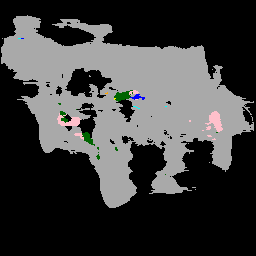

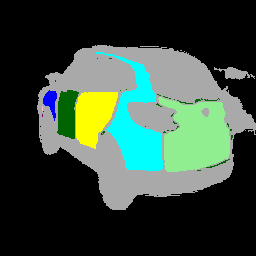

In [28]:
def infere_display(model, car, labels):
    display_car(car)
    with torch.inference_mode():
        out = torch.nn.Softmax2d()(model(car.to(device))[0])
        out = np.moveaxis(out.cpu().numpy(), 0, 2)
        out = np.argmax(out, axis=2)
        display_labels(out)
        display_labels(labels)

        
car, labels = photo_test_ds[2]
infere_display(model, car, labels)

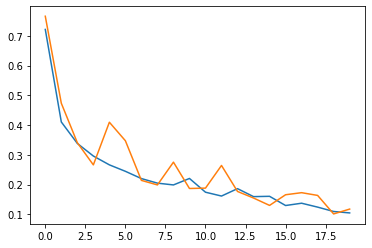

In [26]:
import matplotlib.pyplot as plt

plt.plot(avg_train_losses)
plt.plot(avg_test_losses)
plt.show()